In [1]:
# import libraries
import mne
import os
import numpy as np
from scipy.signal import sosfiltfilt, butter
import neurokit2 as nk
mne.viz.set_browser_backend('matplotlib')

Using matplotlib as 2D backend.


Extracting parameters from D:\data\data_testing\04466_S021_T002\04466_S021_T002.vhdr...
Setting channel info structure...
Reading 0 ... 132640  =      0.000 ...   518.125 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, AF3, AF4, FCz, F3, Fz, F4, CPz, PO3, FC1, Cz, ...
 chs: 32 EEG, 1 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 256.0 Hz
>


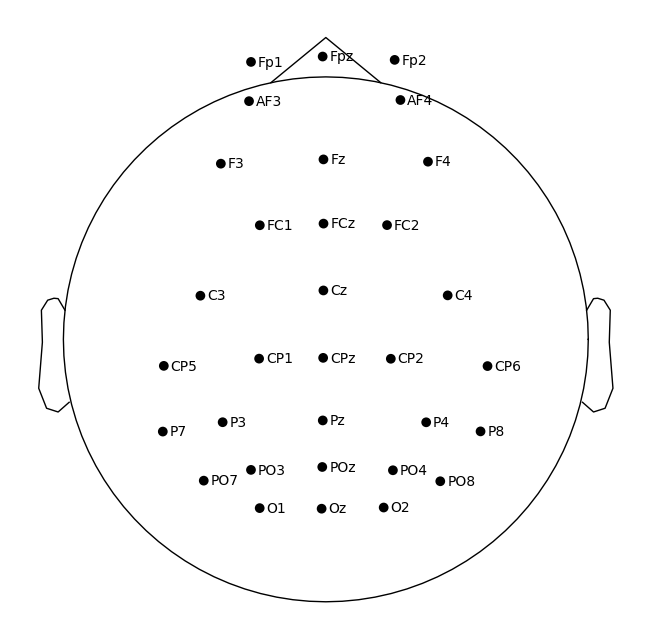

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, AF3, AF4, FCz, F3, Fz, F4, CPz, PO3, FC1, Cz, ...
 chs: 32 EEG, 1 EOG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 256.0 Hz
>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 0.10, 20.00 Hz: -6.02, -6.02 dB



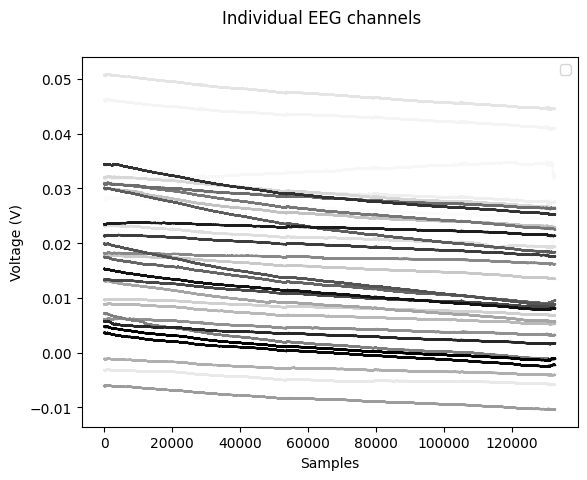

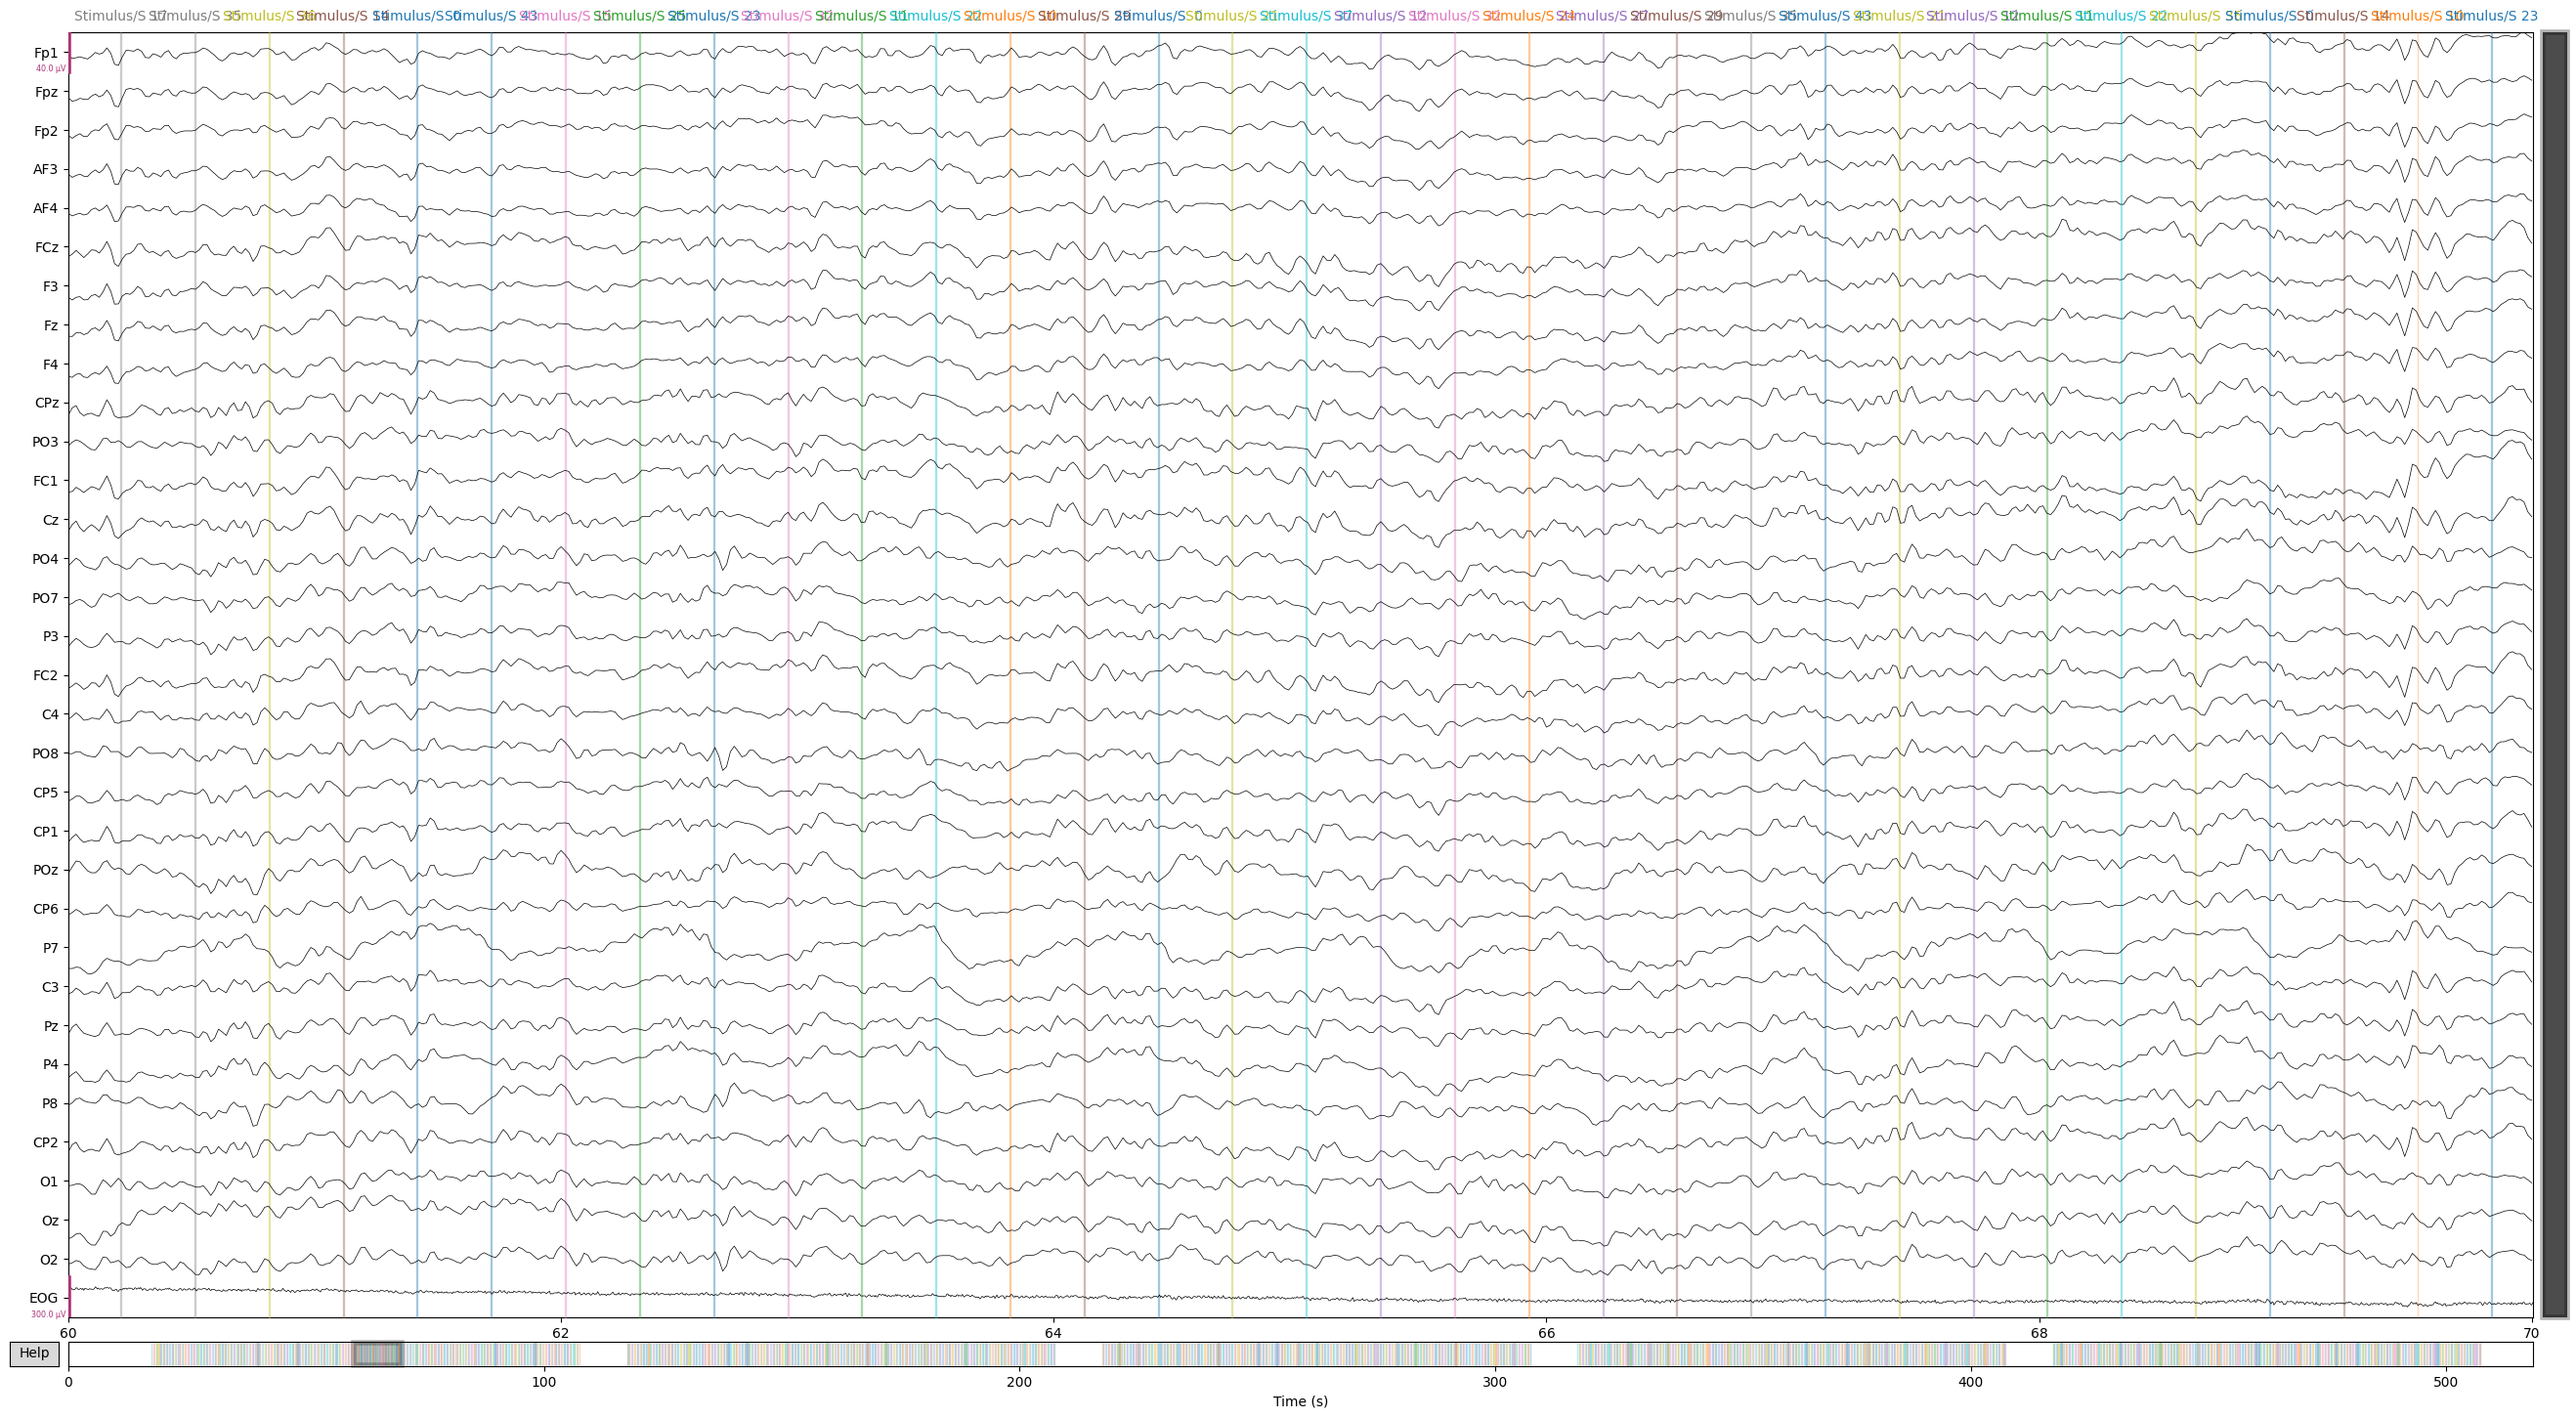

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\neuramod\AppData\Local\Temp\ipykernel_18736\874500797.py:28: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  nth.interpolate_bads(reset_bads=True)


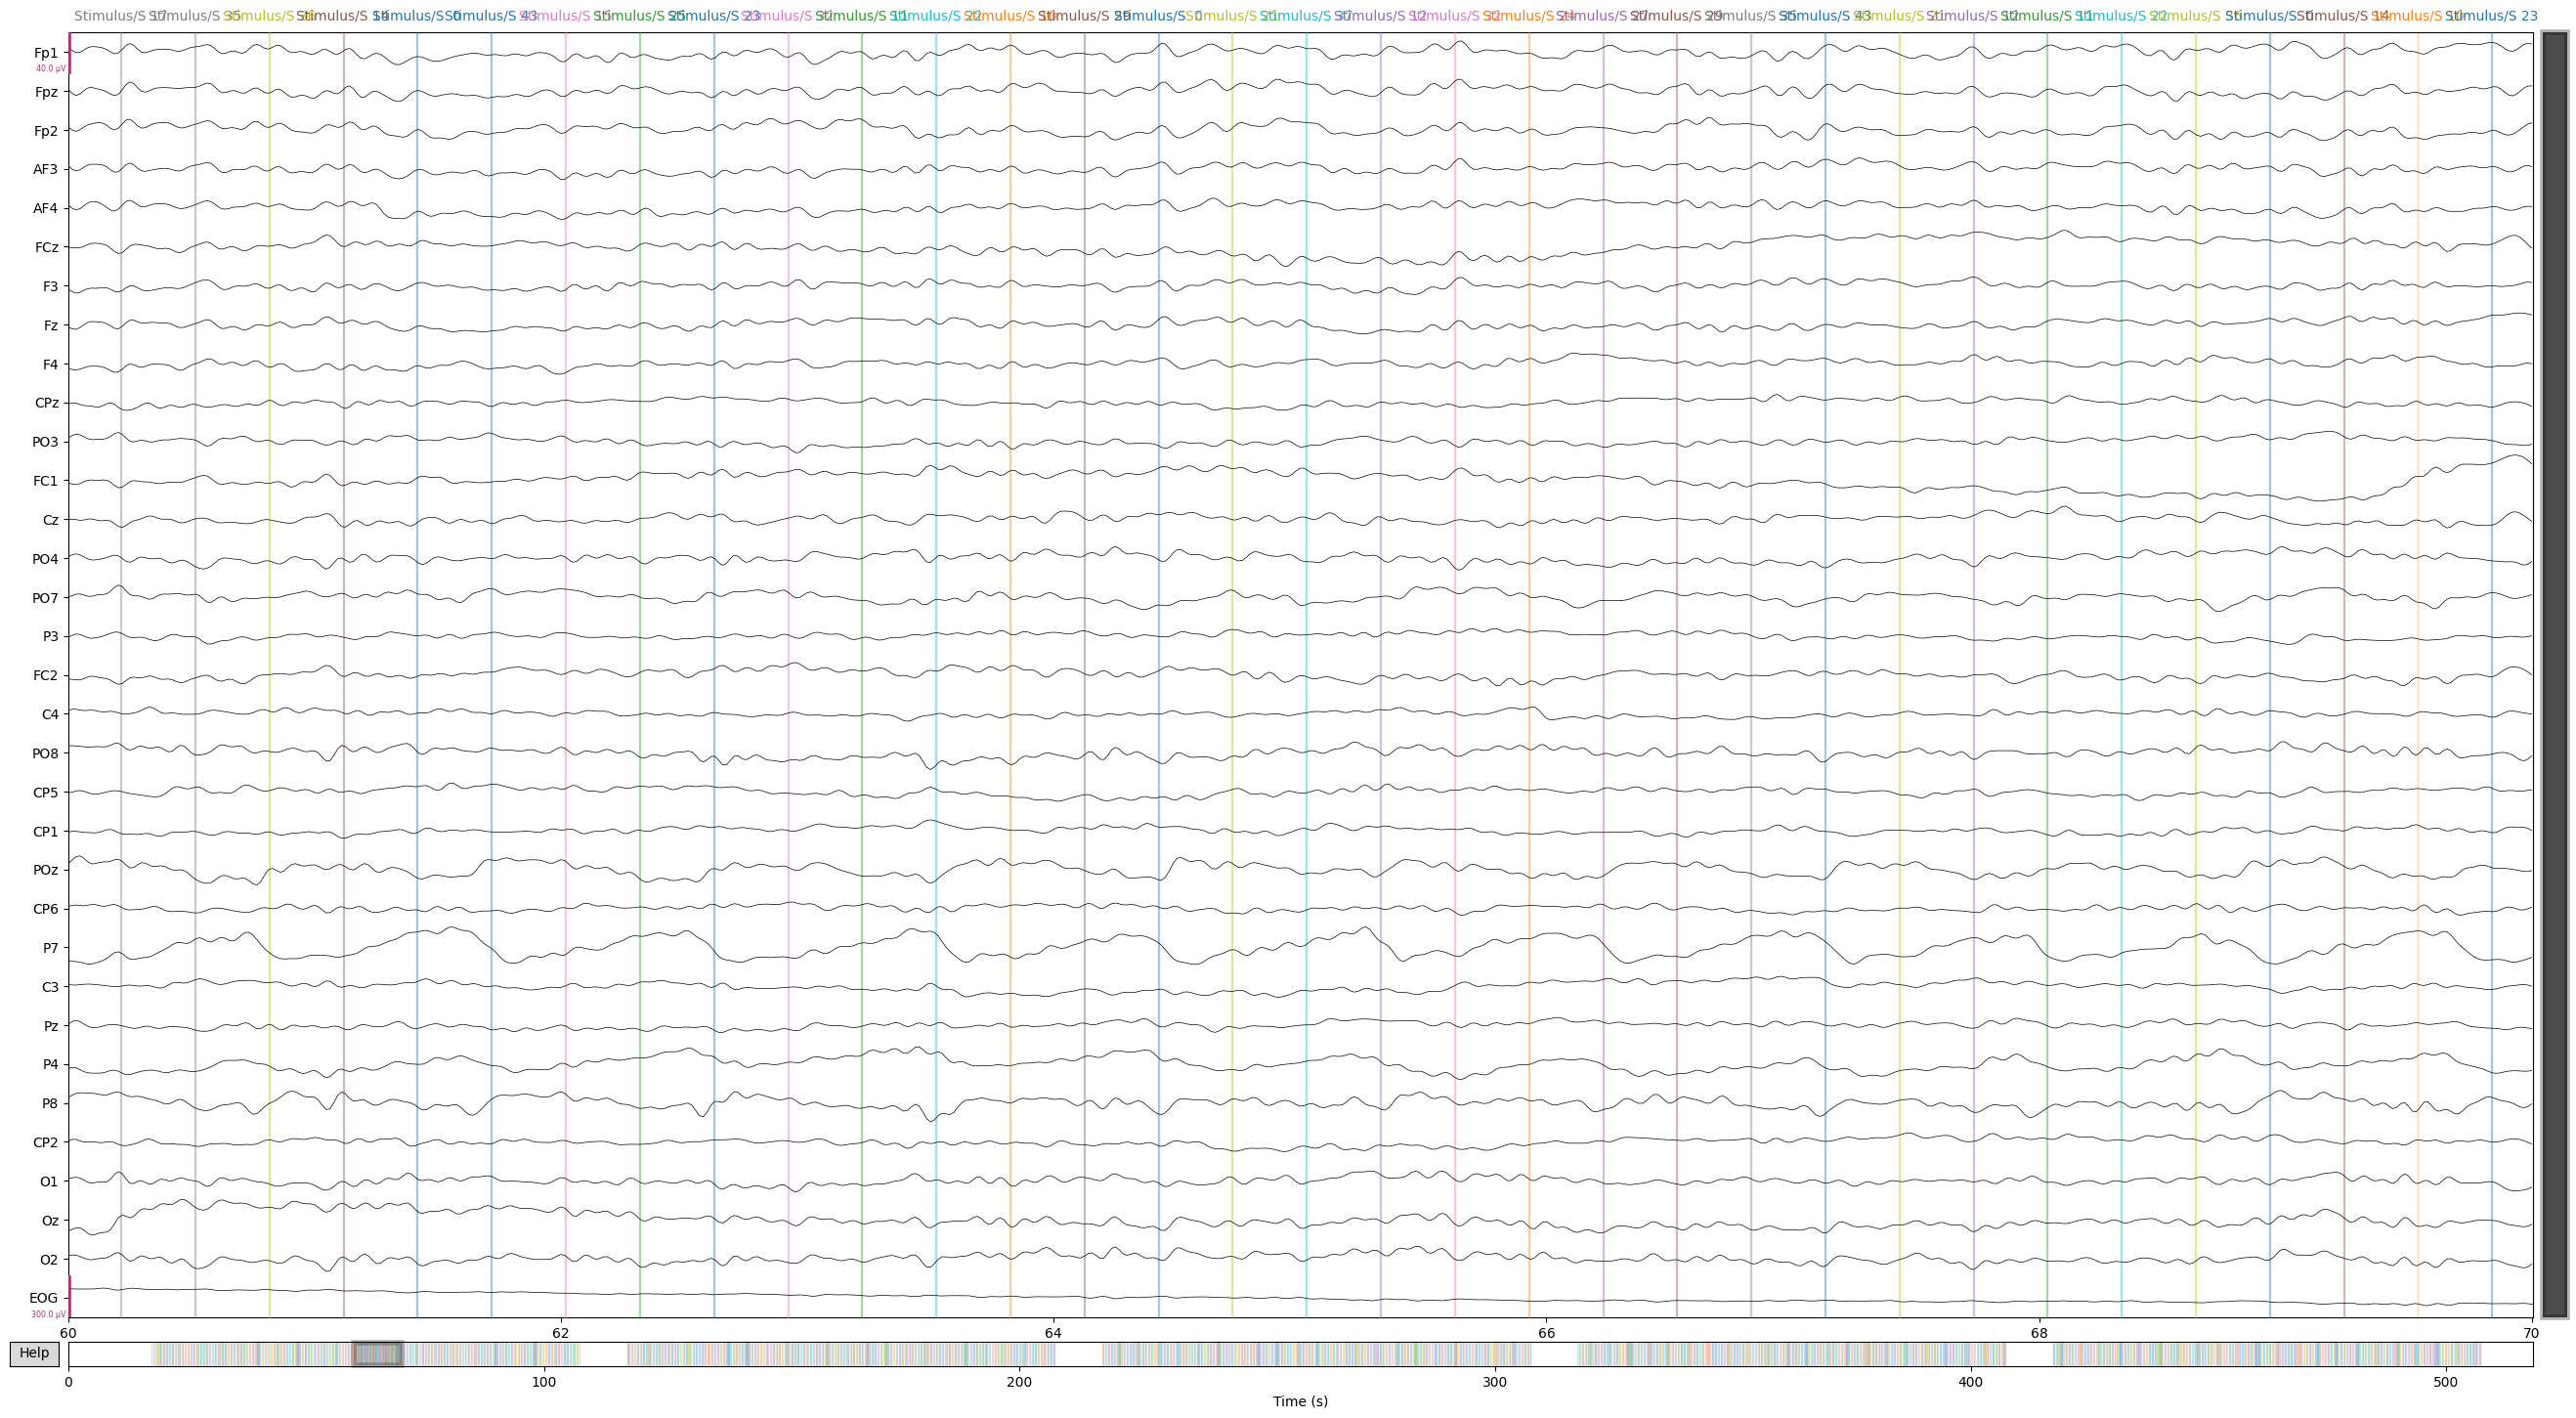

Used Annotations descriptions: ['Stimulus/S  0', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 17', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 23', 'Stimulus/S 24', 'Stimulus/S 25', 'Stimulus/S 27', 'Stimulus/S 29', 'Stimulus/S 32', 'Stimulus/S 35', 'Stimulus/S 36', 'Stimulus/S 37', 'Stimulus/S 43']
Event ids before merging: {'Stimulus/S  0': 0, 'Stimulus/S 10': 10, 'Stimulus/S 11': 11, 'Stimulus/S 12': 12, 'Stimulus/S 14': 14, 'Stimulus/S 15': 15, 'Stimulus/S 17': 17, 'Stimulus/S 21': 21, 'Stimulus/S 22': 22, 'Stimulus/S 23': 23, 'Stimulus/S 24': 24, 'Stimulus/S 25': 25, 'Stimulus/S 27': 27, 'Stimulus/S 29': 29, 'Stimulus/S 32': 32, 'Stimulus/S 35': 35, 'Stimulus/S 36': 36, 'Stimulus/S 37': 37, 'Stimulus/S 43': 43}
Event ids after merging: {'target:0': 0, 'distractors': 1}
Not setting metadata
1500 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1500 eve

In [2]:
def preprocess(the_data):
    
    the_data_path = os.path.join(the_drive,os.sep,the_repo,the_subrepo,the_type,the_data)
    exp = mne.io.read_raw_brainvision(the_data_path, preload=True)
    exp.set_channel_types(mapping={'EOG': 'eeg'})
    exp.rename_channels(mapping={'EOG': 'EOG'})
    exp.set_channel_types(mapping={'EOG': 'eog'})
    print(exp.info)
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
    raw_1020 = exp.copy().set_montage(ten_twenty_montage)
    raw_1020.plot_sensors(show_names=True)
    bads, info = nk.eeg_badchannels(raw_1020, bad_threshold=0.5,distance_threshold=0.96, show=True)
    raw_1020.info['bads'] = bads
    print(raw_1020.info)
    ## band-pass filter ##
    filt=raw_1020.filter(0.1, 20,method='iir', iir_params=dict(order=5, ftype='butter', output='sos', picks='eeg', exclude='bads'))
    filt.plot(duration = 10, start = 60, n_channels=len(filt.ch_names))
    ## notch filter ##
    pl_freq=50.
    ny_freq=128.
    nth = filt.notch_filter(np.arange(pl_freq, ny_freq, pl_freq), fir_design='firwin')
    ## detrending ##
    b = nth._data
    sos = butter(20, 0.1, output='sos')
    y = sosfiltfilt(sos, b)
    nth._data = y
    ## interpolation ##
    nth.interpolate_bads(reset_bads=True)
    ## reference ##
    ref_data= nth.set_eeg_reference(ref_channels='average')
    ref_data.plot(duration = 10, start = 60, n_channels=len(filt.ch_names))
    ## event annotation ##
    events,event_ids = mne.events_from_annotations(ref_data)
    print('Event ids before merging:', event_ids)
    ## Epoching ##
    merged_events = mne.merge_events(events,range(10,45), 1) # merging events #
    mapping = {0: 'target:0', 1:'distractors'} 
    annot_from_events = mne.annotations_from_events(
            events=events, event_desc=mapping, sfreq=exp.info['sfreq'],
                    orig_time=ref_data.info['meas_date'])
    ref_data.set_annotations(annot_from_events)
    event_id={'target:0': 0,'distractors':1} 
    print('Event ids after merging:', event_id)
    picks = mne.pick_types(ref_data.info, meg=False, eeg=True, stim=False, eog=True,
                   exclude='bads')
    epochs = mne.Epochs(ref_data, merged_events, event_id=event_id, tmin=-0.2, tmax=0.8, 
                    baseline=(-0.2, 0), preload=True,reject=dict(eeg=150e-6, eog=100e-6),reject_by_annotation='bad',picks=picks)
    conditions = ['target:0','distractors']
    evokeds = {c:epochs[c].average() for c in conditions}
    for condition in evokeds.keys():
        evokeds[condition].comment = condition
    print(evokeds)
    mne.write_evokeds( the_type + '-ave.fif', list(evokeds.values()))
    return epochs

                        #####################################################################
                                        # SCRIPT CALL OR MODULE IMPORT #
                        #####################################################################
if __name__ == '__main__':


    data_name = "04466_S021_T002"
    the_drive = "D:"
    the_repo = "data"
    the_subrepo = "data_testing"
    the_type = "04466_S021_T002"
    the_data = f"{data_name}.vhdr"
    preprocess(the_data)